In [ ]:
!pip install requests
!pip install pandas
!pip install mp-api
!pip install requests-html

In [1]:
import csv
import os
import pandas as pd
import math
import random
import seaborn as sb
import subprocess

In [2]:
ROOT_DIR = os.path.abspath("")
#DATA_DIR = os.path.join(ROOT_DIR, 'CrabNet/data/materials_data')
DATA_DIR = os.path.join(ROOT_DIR, 'CrabNet/data/materials_data/example_materials_property')
TRAINING_CSV_FILE = os.path.join(ROOT_DIR, "Vacancyenergydata.csv")
API_KEY = "3XX6x9Nd3cKWf9Q4wpaio64CBHFp2uDq"
TRAINING_DATA = []

print(DATA_DIR)

/home/murimikelvin/ML-perovskites-project/CrabNet/data/materials_data/example_materials_property


## Step1:Collecting data and cleaning the data.


#### Load Training data.

In [3]:
df = pd.read_csv(TRAINING_CSV_FILE)
print(df.columns)
df = df[['Chemical formula', 'Vacancy energy [eV/O atom]']]
new_names = {
    'Chemical formula': 'chem_formula',
    'Vacancy energy [eV/O atom]': 'e_ovac'
}
df.rename(columns=new_names, inplace=True)
df = df.to_dict("records")
df = [{'chem_formula': m['chem_formula'], 'e_ovac': float(m['e_ovac']) if m['e_ovac'] != '-' else '-'} for m in df]

df[:10]

Index(['Chemical formula', 'A', 'B', 'In literature', 'Valence A', 'Valence B',
       'Radius A [ang]', 'Radius B [ang]', 'Lowest distortion',
       'Formation energy [eV/atom]', 'Stability [eV/atom]',
       'Magnetic moment [mu_B]', 'Volume per atom [A^3/atom]', 'Band gap [eV]',
       'a [ang]', 'b [ang]', 'c [ang]', 'alpha [deg]', 'beta [deg]',
       'gamma [deg]', 'Vacancy energy [eV/O atom]'],
      dtype='object')


[{'chem_formula': 'Ac2O3', 'e_ovac': 3.15},
 {'chem_formula': 'AcAgO3', 'e_ovac': 0.817},
 {'chem_formula': 'AcAlO3', 'e_ovac': 6.695},
 {'chem_formula': 'AcAsO3', 'e_ovac': 3.634},
 {'chem_formula': 'AcAuO3', 'e_ovac': 0.807},
 {'chem_formula': 'AcBO3', 'e_ovac': 4.163},
 {'chem_formula': 'AcBaO3', 'e_ovac': -1.771},
 {'chem_formula': 'AcBeO3', 'e_ovac': -0.08},
 {'chem_formula': 'AcBiO3', 'e_ovac': 2.653},
 {'chem_formula': 'AcCaO3', 'e_ovac': -1.025}]

## Step 2: Data splitting

####  Splitting model data

In [4]:
# Splitting the data into training and predicting and saving this data.
TRAINING_DATA = [m for m in df if m['e_ovac'] != '-']
PREDICTION_DATA = [m for m in df if m['e_ovac'] == '-']


print("Materials in the csv file without E_Ovac: ", len(PREDICTION_DATA))
print("Materials in the csv file with E_Ovac: ", len(TRAINING_DATA))
print("Total materials in the csv file: ", len(df))


Materials in the csv file without E_Ovac:  415
Materials in the csv file with E_Ovac:  4914
Total materials in the csv file:  5329


In [5]:
print(TRAINING_DATA[0])

{'chem_formula': 'Ac2O3', 'e_ovac': 3.15}


In [6]:
print(PREDICTION_DATA[0])

{'chem_formula': 'AcMgO3', 'e_ovac': '-'}


In [7]:
print(min([x.get('e_ovac') for x in TRAINING_DATA]))
print(max([x.get('e_ovac') for x in TRAINING_DATA]))

-21.785
6.962


#### Create Model Training Data (Create train.csv, val.csv, test.csv)

In [8]:
## Split the data into train, test, val

random.shuffle(TRAINING_DATA) # Shuffle the training data list on every run
split_ratio = "6:2:2" # Set the ratio at with to split the data into train, test and validation sets from the training data list

ratios = [round(int(r)/10 * len(TRAINING_DATA)) for r in split_ratio.split(':')] # Get the number of materials from the training data list according tp the ratio

# Get X amount of data from the training dataset accoring to the set rratio
train_set = TRAINING_DATA[:ratios[0]] 
test_set = TRAINING_DATA[ratios[0]:(ratios[0] + ratios[1])]
val_set = TRAINING_DATA[(ratios[0] + ratios[1]):]

print(len(train_set), len(test_set), len(val_set))
print(ratios, sum(ratios), len(TRAINING_DATA))

print(train_set[:5])
print(test_set[:5])
print(val_set[:5])

2948 983 983
[2948, 983, 983] 4914 4914
[{'chem_formula': 'InTiO3', 'e_ovac': 2.919}, {'chem_formula': 'KPbO3', 'e_ovac': -0.959}, {'chem_formula': 'MgSrO3', 'e_ovac': -6.291}, {'chem_formula': 'UPdO3', 'e_ovac': 0.772}, {'chem_formula': 'AlSrO3', 'e_ovac': -10.222}]
[{'chem_formula': 'GeAcO3', 'e_ovac': -3.55}, {'chem_formula': 'PbGdO3', 'e_ovac': -0.992}, {'chem_formula': 'EuGdO3', 'e_ovac': -0.954}, {'chem_formula': 'NpYbO3', 'e_ovac': -0.865}, {'chem_formula': 'ErZnO3', 'e_ovac': -0.385}]
[{'chem_formula': 'AsPtO3', 'e_ovac': -0.43}, {'chem_formula': 'AsTlO3', 'e_ovac': -5.074}, {'chem_formula': 'MgCaO3', 'e_ovac': -5.014}, {'chem_formula': 'NbIrO3', 'e_ovac': -3.832}, {'chem_formula': 'CeSiO3', 'e_ovac': 4.632}]


In [9]:
## Save data to CSV

fields = ['formula', 'target']
train_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in train_set]
val_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in val_set]
test_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in test_set]

# print(rows)
## Create train.csv with train_set data
with open(os.path.join(DATA_DIR, 'train.csv'), 'w') as train_file:
    csvwriter = csv.writer(train_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(train_rows)

## Create val.csv with train_set data
with open(os.path.join(DATA_DIR, 'val.csv'), 'w') as val_file:
    csvwriter = csv.writer(val_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(val_rows)

## Create test.csv with train_set data
with open(os.path.join(DATA_DIR, 'test.csv'), 'w') as test_file:
    csvwriter = csv.writer(test_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(test_rows)
    

#### Train the crabnet model

In [10]:



os.chdir ('CrabNet')
command = f"python train_crabnet.py"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in process.stdout:
    print(line.decode("utf-8"), end='')


Property "example_materials_property" selected for training

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 3 elements in the formula
training with batchsize 256 (2**8.000)
loading data with up to 3 elements in the formula
stepping every 12 training passes, cycling lr every 1 epochs
checkin at 2 epochs to match lr scheduler
Epoch: 0/40 --- train mae: 3.33 val mae: 3.37
Epoch: 1/40 --- train mae: 3.16 val mae: 3.25
Epoch: 3/40 --- train mae: 2.98 val mae: 3.11
Epoch: 5/40 --- train mae: 2.96 val mae: 3.12
Epoch 7 failed to improve.
Discarded: 1/3 weight updates ♻🗑️
Epoch: 7/40 --- train mae: 3.07 val mae: 3.19
Epoch: 9/40 --- train mae: 2.88 val mae: 3.08
Epoch: 11/40 --- train mae: 2.83 val mae: 3.05
Epoch: 13/40 --- train mae: 2.8 val mae: 3.06
Epoch: 15/40 --- train mae: 2.79 val mae: 3.03
Epoch: 17/40 --- train mae: 2.76 val mae: 3.06
Epoch: 19/40 --- train mae: 2.79 val mae: 3.06
E

#### Analyzing training performance

Text(0, 0.5, 'Predicted Eovac(eV/O atom)')

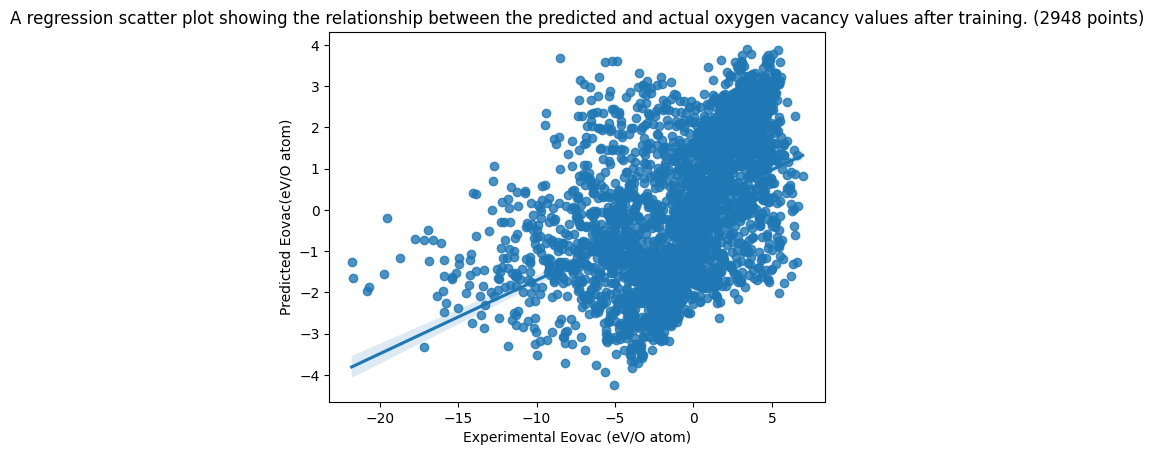

In [11]:

csv_df = pd.read_csv('model_predictions/example_materials_property_train_output.csv')

ax = sb.regplot(x='target', y='pred-0', data=csv_df)
ax.set_title(f"A regression scatter plot showing the relationship between the predicted and actual oxygen vacancy values after training. ({len(csv_df)} points)")
ax.set_xlabel("Experimental Eovac (eV/O atom)")
ax.set_ylabel("Predicted Eovac(eV/O atom)")


#### Create Prediction Data (Create train.csv, val.csv, test.csv)

In [12]:
## Split the data into train, test, val

random.shuffle(PREDICTION_DATA) # Shuffle the training data list on every run
split_ratio = "6:2:2" # Set the ratio at with to split the data into train, test and validation sets from the training data list

ratios = [round(int(r)/10 * len(PREDICTION_DATA)) for r in split_ratio.split(':')] # Get the number of materials from the training data list according tp the ratio

# Get X amount of data from the training dataset accoring to the set rratio
train_set = PREDICTION_DATA[:ratios[0]] 
test_set = PREDICTION_DATA[ratios[0]:(ratios[0] + ratios[1])]
val_set = PREDICTION_DATA[(ratios[0] + ratios[1]):]

print(len(train_set), len(test_set), len(val_set))
print(ratios, sum(ratios), len(PREDICTION_DATA))

print(train_set[:5])
print(test_set[:5])
print(val_set[:5])

249 83 83
[249, 83, 83] 415 415
[{'chem_formula': 'PuScO3', 'e_ovac': '-'}, {'chem_formula': 'CaLaO3', 'e_ovac': '-'}, {'chem_formula': 'TcCaO3', 'e_ovac': '-'}, {'chem_formula': 'CdSmO3', 'e_ovac': '-'}, {'chem_formula': 'CoEuO3', 'e_ovac': '-'}]
[{'chem_formula': 'ReCsO3', 'e_ovac': '-'}, {'chem_formula': 'PuNpO3', 'e_ovac': '-'}, {'chem_formula': 'DyCsO3', 'e_ovac': '-'}, {'chem_formula': 'Pa2O3', 'e_ovac': '-'}, {'chem_formula': 'NiCsO3', 'e_ovac': '-'}]
[{'chem_formula': 'NpBiO3', 'e_ovac': '-'}, {'chem_formula': 'CaCdO3', 'e_ovac': '-'}, {'chem_formula': 'NiFeO3', 'e_ovac': '-'}, {'chem_formula': 'CoCsO3', 'e_ovac': '-'}, {'chem_formula': 'Pt2O3', 'e_ovac': '-'}]


In [13]:
## Save data to CSV

fields = ['formula', 'target']
train_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in train_set]
val_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in val_set]
test_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in test_set]

# print(rows)
## Create train.csv with train_set data
with open(os.path.join(DATA_DIR, 'train.csv'), 'w') as train_file:
    csvwriter = csv.writer(train_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(train_rows)

## Create val.csv with train_set data
with open(os.path.join(DATA_DIR, 'val.csv'), 'w') as val_file:
    csvwriter = csv.writer(val_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(val_rows)

## Create test.csv with train_set data
with open(os.path.join(DATA_DIR, 'test.csv'), 'w') as test_file:
    csvwriter = csv.writer(test_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(test_rows)
    

In [14]:
print(min([x.get('e_ovac') for x in TRAINING_DATA]))

-21.785


#### Predicting EOvac values 

In [15]:
#os.chdir ('CrabNet')

command = f"python predict_crabnet.py"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in process.stdout:
    print(line.decode("utf-8"), end='')

              example_materials_property             
calculating train mae
loading data with up to 3 elements in the formula
example_materials_property mae: 1.57
-----------------------------------------------------
calculating val mae
loading data with up to 3 elements in the formula
example_materials_property mae: 1.4
-----------------------------------------------------
calculating test mae
loading data with up to 3 elements in the formula
example_materials_property mae: 1.75


#### Analyze predicted values

In [16]:
## Read the predictions from the csv files

PRED_DIR = os.path.join(ROOT_DIR, "CrabNet/model_predictions/")
print(PRED_DIR)
csv_files = os.listdir(PRED_DIR)

predicted_data = []
for _file in csv_files:
    with open(os.path.join(PRED_DIR, _file)) as train_file:
        csv_reader = csv.reader(train_file)
        
        row_count = 0
        for row in csv_reader:
            if row_count != 0:
#                 print(row)
                predicted_data.append({
                    "structure": row[1],
                    "predicted_e_ovac": float(row[3])
                })
            
            row_count += 1

            
print(predicted_data[:5])
print(len(predicted_data))
 

/home/murimikelvin/ML-perovskites-project/CrabNet/model_predictions/
[{'structure': 'ReCsO3', 'predicted_e_ovac': -1.2834116220474243}, {'structure': 'PuNpO3', 'predicted_e_ovac': 2.6822125911712646}, {'structure': 'DyCsO3', 'predicted_e_ovac': -0.8842887878417969}, {'structure': 'Pa2O3', 'predicted_e_ovac': 2.6993775367736816}, {'structure': 'NiCsO3', 'predicted_e_ovac': -1.4094966650009155}]
415


In [17]:
print(min([x.get('predicted_e_ovac') for x in predicted_data]))
print(max([x.get('predicted_e_ovac') for x in predicted_data]))

-3.4582359790802
3.4941532611846924


In [31]:
df = pd.DataFrame(predicted_data)
df = df.sort_values(by = 'predicted_e_ovac')
df.to_csv('predictions.csv', index=False)


print(df.head())
print(len(predicted_data))

    structure  predicted_e_ovac
68     NiBeO3         -3.458236
100     Ni2O3         -3.169797
235    NiAlO3         -2.979170
270    NiCuO3         -2.890724
392    NiZnO3         -2.767043
415


##### Plot of the top and bottom 20 materials

Text(0.5, 0, 'Chemical Structure')

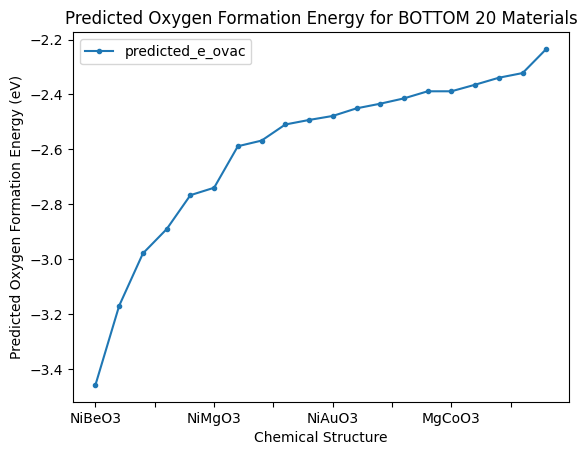

In [29]:
NUMBER = 20

new_df = (df[:NUMBER])

ax = new_df.plot(style='.-', x='structure', y='predicted_e_ovac')
ax.set_title(f"Predicted Oxygen Formation Energy for BOTTOM {NUMBER} Materials")
ax.set_ylabel('Predicted Oxygen Formation Energy (eV)')
ax.set_xlabel("Chemical Structure")

Text(0.5, 0, 'Chemical Structure')

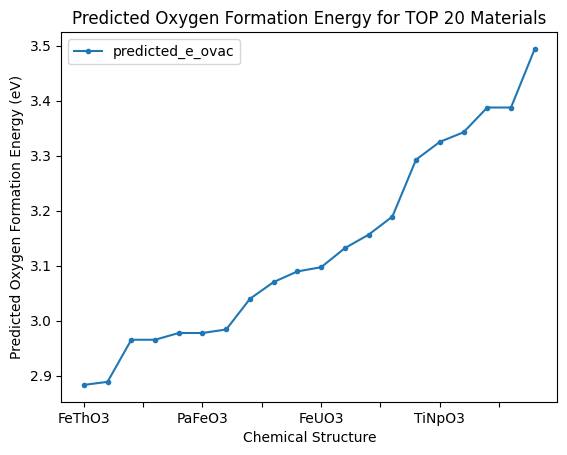

In [30]:
NUMBER = 20

new_df = df[-NUMBER:]

ax = new_df.plot(style='.-', x='structure', y='predicted_e_ovac')
ax.set_title(f"Predicted Oxygen Formation Energy for TOP {NUMBER} Materials")
ax.set_ylabel('Predicted Oxygen Formation Energy (eV)')
ax.set_xlabel("Chemical Structure")